In [1]:
!pip install tensorflow-datasets
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 63.2 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load COCO 2017 dataset with annotations
dataset, info = tfds.load('coco/2017', with_info=True, data_dir='/notebooks/tensorflow_datasets')
num_classes = 80 # number of classes in COCO dataset

In [4]:
def create_datasets_from_coco(dataset, transform_image, num_classes):
    def encode_coco_categories(coco_categories, num_classes):
        return tf.reduce_max(tf.one_hot(coco_categories, num_classes), axis=0)

    def set_labels_as_zeros():
        return tf.zeros(num_classes, tf.float32)

    def preprocess(example, transform_image):
        image = example['image']
        image = transform_image(image)

        coco_categories = example['objects']['label']
        is_empty = tf.equal(tf.size(coco_categories), 0)
        labels = tf.cond(is_empty, set_labels_as_zeros, lambda: encode_coco_categories(coco_categories, num_classes))
        return image, labels

    batch_size = 32

    train_ds = dataset['train'].map(lambda x: preprocess(x, transform_image)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = dataset['validation'].map(lambda x: preprocess(x, transform_image)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

## Create your own model

In [5]:
def transform_image(image):
    image = tf.image.resize(image, (227, 227))
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    mean = [0.485, 0.456, 0.406]
    variance = [0.229, 0.224, 0.225]
    normalization_layer = Normalization(mean=mean, variance=variance)
    image = normalization_layer(image)
    return image

train_ds, val_ds = create_datasets_from_coco(dataset, transform_image, num_classes)

input_shape = (227, 227, 3)

model = Sequential()
# Convolutional layers
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation="relu", input_shape=input_shape, padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Conv2D(384, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dropout(0.5))
model.add(Dense(4096, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="sigmoid"))

# Compile the model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

## Or load pretrained archtecture and change the last layer

In [6]:
def transform_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image
    
train_ds, val_ds = create_datasets_from_coco(dataset, transform_image, num_classes)

# Load the VGG16 model without the top layers
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add top layers for multi-label classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu', name='dense_additional1')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='dense_additional2')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Print the layer names
print(*(layer.name for layer in model.layers), sep=' -> ')

optimiser = tf.keras.optimizers.Adam(learning_rate=1e-5)
f1_score = tfa.metrics.F1Score(num_classes=num_classes, average='macro')
# Compile the model
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=[f1_score])

58889256/58889256 [==============================] - 1s 0us/step
input_1 -> block1_conv1 -> block1_conv2 -> block1_pool -> block2_conv1 -> block2_conv2 -> block2_pool -> block3_conv1 -> block3_conv2 -> block3_conv3 -> block3_pool -> block4_conv1 -> block4_conv2 -> block4_conv3 -> block4_pool -> block5_conv1 -> block5_conv2 -> block5_conv3 -> block5_pool -> global_average_pooling2d -> dense_additional1 -> dropout_2 -> dense_additional2 -> dropout_3 -> dense_3


## Train and save

Epoch 1/10
3697/3697 [==============================] - 407s 108ms/step - loss: 0.2306 - f1_score: 0.0605 - val_loss: 0.0950 - val_f1_score: 0.1583
Epoch 2/10
3697/3697 [==============================] - 400s 108ms/step - loss: 0.1162 - f1_score: 0.1434 - val_loss: 0.0841 - val_f1_score: 0.2211
Epoch 3/10
3697/3697 [==============================] - 399s 108ms/step - loss: 0.0996 - f1_score: 0.1895 - val_loss: 0.0805 - val_f1_score: 0.2498
Epoch 4/10
3697/3697 [==============================] - 399s 108ms/step - loss: 0.0920 - f1_score: 0.2143 - val_loss: 0.0783 - val_f1_score: 0.2668
Epoch 5/10
3697/3697 [==============================] - 399s 108ms/step - loss: 0.0874 - f1_score: 0.2329 - val_loss: 0.0771 - val_f1_score: 0.2776
Epoch 6/10
3697/3697 [==============================] - 398s 108ms/step - loss: 0.0841 - f1_score: 0.2444 - val_loss: 0.0761 - val_f1_score: 0.2885
Epoch 7/10
3697/3697 [==============================] - 399s 108ms/step - loss: 0.0816 - f1_score: 0.2541 - val_

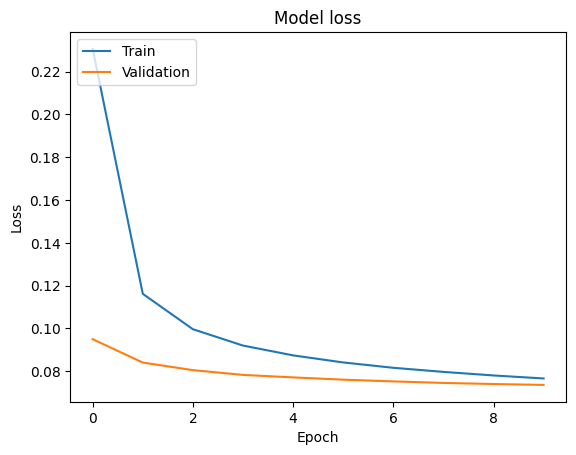

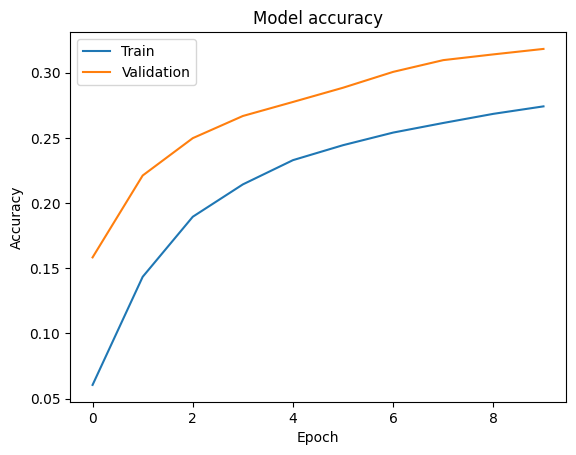

In [7]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)
model.save('model.h5')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history[f1_score.name])
plt.plot(history.history[f'val_{f1_score.name}'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
